In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import statistics as stat
import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

In [11]:
experiments = [
    "NORT-Proxima_dynamicalpha", #Proxima - dynamic alpha with no retrain interval
    "NORT-Proxima_static-alpha", #Proxima - precalcualted alpha, no retrain interval
    "surrogate_only", ## Simple surrogate implementation
    "SS-UQ02-NORT_staticalpha", # Simple surrogate, uq:0.2, no retrain interval
    "DA_RT50", ## Proxima - dynamica alpha, testing single RT interval of 50 
    "DAallUQ_TEMP1000", ## Proxima - testing different retrain intervals and UQ's
    "SST1000_bestparameters", ## Simple surrogate - with different Retrain intervals tested
    "SS_RI300", ## Simple Surrogate with RI 300
    "SS-UQ02_I50", ## Simple surrogate, uq: 0.2, All temps, RI: 50
    "SS-UQall_I50", ## Simple surrogate,, all UQ, Temp: 500, RI: 50
    "dyn_nostreak", ##Proxima - dynamic alpha, no surrogate streak option
]
root_path = "../proxima_data"

## Loading high fidelity times

In [12]:
root_path_hf = "../proxima_data"
path_str = "/".join([root_path_hf,"runtime_s1_data.csv"])
hf_times = pd.read_csv(path_str)
average_rt = hf_times['Runtime[s]'].mean()
average_rt
#float(hf_times.set_index('Temp[K]').loc[100])

532.3645715755877

In [13]:
hf_times

,Temp[K],Runtime[s]
0,100,516.687530
1,200,523.776283
2,300,532.178107
3,400,528.386581
4,500,529.334293
5,600,519.650676
6,700,522.845046
7,800,518.376097
8,900,601.335490
9,1000,531.075613


## Loading results of all experiments

In [14]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

In [16]:
def graph_values(name):
    _t_sa = results[name]['time']
    _speedup_sa = results[name]['speed_up']
    _temp_sa = results[name]['temperature']
   
    _temp_sa, _t_sa, _speedup_sa = zip(*sorted(zip(_temp_sa, _t_sa,_speedup_sa)))
    hm_sp_sa = stat.harmonic_mean(_speedup_sa)
    hm_t_sa = stat.harmonic_mean(_t_sa)
    _speedup_sa = _speedup_sa + (hm_sp_sa,)
    _t_sa = _t_sa + (hm_t_sa,)
    _temp_sa = _temp_sa + ('HM',)
    return _speedup_sa,_t_sa, _temp_sa
    
_speedup_sa,_t_sa,_temp_sa = graph_values("NORT-Proxima_static-alpha")
_speedup_da,_t_da,_temp_da = graph_values("NORT-Proxima_dynamicalpha")
_speedup_ssnort,_t_ssnort, _temp_ssnort = graph_values("SS-UQ02-NORT_staticalpha")
_speedup_ss,_t_ss,_temp_ss = graph_values("SS-UQ02_I50")
_speedup_ss300,_t_ss300,_temp_ss300 = graph_values("SS_RI300")
_speedup_nostreak, _t_nostreak, _temp_nostreak = graph_values("dyn_nostreak")

## Graphing Speed-up Comparison: Dynamic vs Simple Surrogate No Retrain Interval 
Simple surrogate uses UQ: 0.2

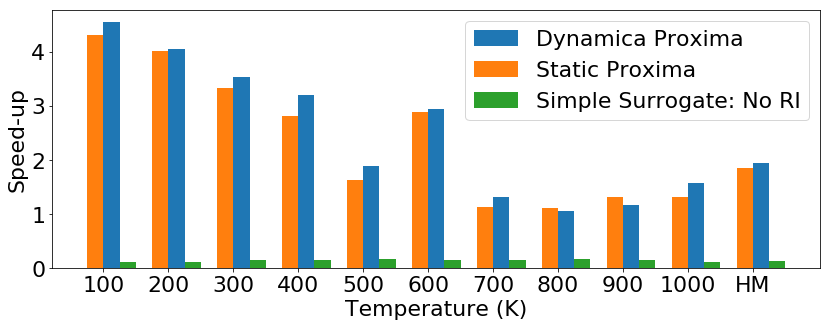

In [44]:
RI= False #set true or false depending on retrain interval usage
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(12,5))

rects1 = ax.bar(x + width/2, list(_speedup_da), width, label='Dynamica Proxima')
rects2 = ax.bar(x - width/2, list(_speedup_sa), width, label='Static Proxima')
if RI:
    rects3 = ax.bar(x + (width/2)+width, list(_speedup_ss300), width, label='Simple Surrogate, RI=300')
else:
    rects3 = ax.bar(x + (width/2)+width, list(_speedup_ssnort), width, label='Simple Surrogate: No RI')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speed-up')

ax.set_xlabel("Temperature (K)")
#ax.set_title('Surrogate Method Comparison: Speed-up Across Temperatures')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()

if RI:
    plt.savefig('Figures/speedup_best.png')
else:
    plt.savefig('Figures/nort_speedup_bar.png')

plt.show()

## Dynamic, Static, No streak VS SS with RI 300

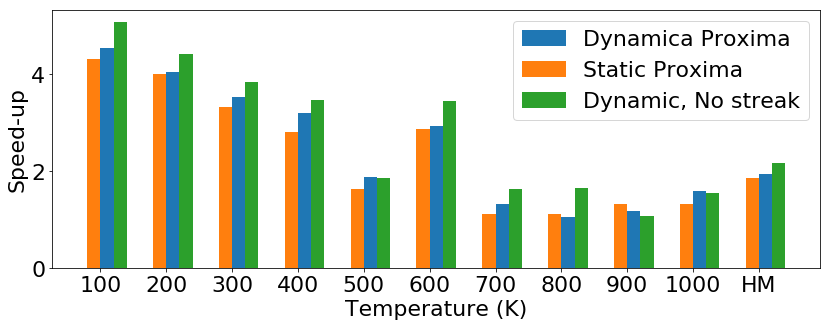

In [48]:
RI= True #set true or false depending on retrain interval usage
SS = False #Comparing with simple surrogate
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars
fig, ax = plt.subplots(figsize=(12,5))

rects1 = ax.bar(x + width/2, list(_speedup_da), width, label='Dynamica Proxima')
rects2 = ax.bar(x - width/2, list(_speedup_sa), width, label='Static Proxima')
rects4 = ax.bar(x + (width/2)+width, list(_speedup_nostreak), width, label='Dynamic, No streak')
if SS:
    if RI:
        rects3 = ax.bar(x + (width/2)+width*2, list(_speedup_ss300), width, label='Simple Surrogate, RI=300')
    else:
        rects3 = ax.bar(x + (width/2)+width*2, list(_speedup_ssnort), width, label='Simple Surrogate: No RI')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speed-up')
ax.set_xlabel("Temperature (K)")
#ax.set_ylim(0,5.5)
#ax.set_title('Surrogate Method Comparison: Speed-up Across Temperatures')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.savefig('Figures/3prox_speedupbar.png')
plt.show()

### Graphing Speed-up Comparison: Dynamic, NO surrogate streak vs Simple Surrogate with 300 RI
Simple surrogate uses UQ: 0.2

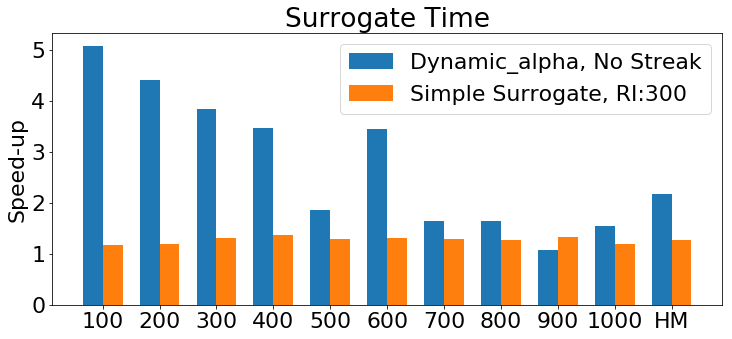

In [23]:
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, list(_speedup_nostreak), width, label='Dynamic_alpha, No Streak')
rects2 = ax.bar(x + width/2, list(_speedup_ss300), width, label='Simple Surrogate, RI:300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speed-up')
ax.set_title('Surrogate Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.savefig('Figures/nostreak_ss_bar.png')


plt.show()

## Graphing Speed-up Comparison: Dynamic vs Simple Surrogate with 300 RI
Simple surrogate uses UQ: 0.2


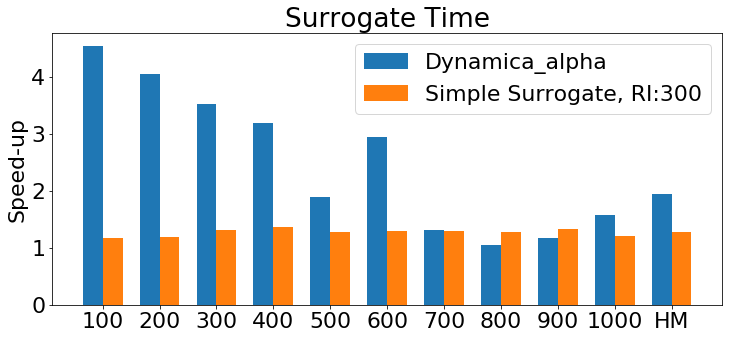

In [24]:
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, list(_speedup_da), width, label='Dynamica_alpha')
rects2 = ax.bar(x + width/2, list(_speedup_ss300), width, label='Simple Surrogate, RI:300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speed-up')
ax.set_title('Surrogate Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('Figures/speedup_best300.png')
plt.show()

## Graphing Time Comparison: Dynamic vs Static Proxima

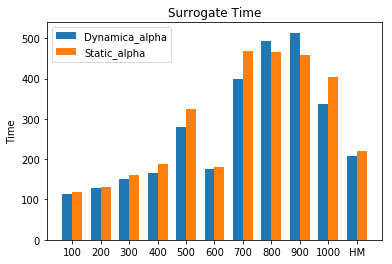

In [30]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, list(_t_da), width, label='Dynamica_alpha')
rects2 = ax.bar(x + width/2, list(_t_sa), width, label='Static_alpha')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title('Surrogate Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



plt.show()

## Graphing Speed-up: Dynamic vs Static Proxima

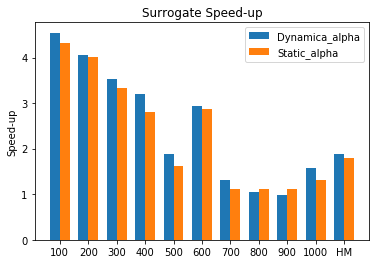

In [31]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, list(_speedup_da), width, label='Dynamica_alpha')
rects2 = ax.bar(x + width/2, list(_speedup_sa), width, label='Static_alpha')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speed-up')
ax.set_title('Surrogate Speed-up')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



plt.show()

## Function to graph cases - only works with two cases

In [32]:
def _plot_cases(cases):
    fig, ax = plt.subplots(figsize=(12,5))
    num_case = len(cases)
    total_width = 0.7
    width = total_width / num_case
    print(num_case)
    for i in range(num_case):
        case = cases[i]
        x_offset = (i - num_case / 2) * width + width / 2
        labels = list(case.get('df'))
        x = np.arange(len(labels))  # the label locations
        y = case.get('y')
        label = case.get('label')
        rects1 = ax.bar(x + x_offset, list(y), width, label=label)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Time')
    ax.set_title('Surrogate Time')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
        

2


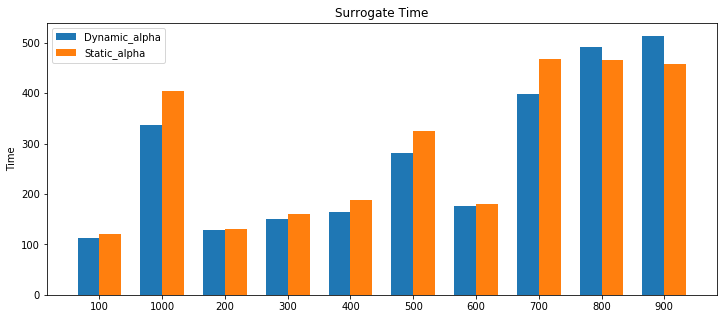

In [33]:
cases = (
        {"df": results["NORT-Proxima_dynamicalpha"]['temperature'],'y': results["NORT-Proxima_dynamicalpha"]['time'],"label":'Dynamic_alpha', "marker":"x"},
        {"df": results["NORT-Proxima_static-alpha"]['temperature'],'y': results["NORT-Proxima_static-alpha"]['time'],"label":'Static_alpha', "marker":"x"},
        #{"df": results["SS-UQ02-NORT_staticalpha"]['temperature'],'y': results["surrogate_only"]['time'],"label":'Simple_Surrogate', "marker":"x"},
    )
_plot_cases(cases)